In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

from heatmap import make_heatmap, matricize_df
import viz_helpers

# Seaborn style defaults. Relevant changes for us are default font, and no ticks for heatmaps
sns.set_theme()

pd.set_option('display.max_rows', 100)
pd.options.display.precision = 3

# Default (all reddit) counts
df = viz_helpers.load_df(wikt=False)

mat = matricize_df(df)
df.head(5)

,pre,suff,count
0,cum,wad,372.0
1,cum,bag,1608.0
2,cum,bucket,4441.0
3,cum,sack,212.0
4,cum,ball,654.0


In [3]:
def shannon_entropy(vec, pseudocount=1):
    """Compute the shannon entropy for given vector of counts for an affix, with
    additive smoothing to deal with 0s.
    
    This is the average number of bits required to communicate a pairing of the affix.
    A higher value means the term is more flexible.
    """
    smoothed = vec + pseudocount
    total = smoothed.sum()
    probs = smoothed / total
    bits = np.log2(probs)
    return -1 * (bits * probs).sum()

# FWIW, did a side-by-side comparison, and the unbiased version is *almost* indistinguishable from
# the basic version, with the exception of the rarest prefix and suffix (harpy- and -mitten, resp)
# which appear approx 10^1-10^2 times. And even then, the displacement is fairly small.
UNBIASED = 1

def collision_probability(vec):
    probs = vec / vec.sum()
    if UNBIASED:
        # probabilities after one item is removed and not replaced
        post_numerators = vec.apply(lambda n: max(0, n-1))
        post_denom = vec.sum() - 1
        post_probs = post_numerators / post_denom
        return (probs * post_probs).sum()
    else:
        return (probs**2).sum()
    
def collision_entropy(vec):
    # zzz
    pseudocount = 1
    vec += pseudocount
    probs = vec / vec.sum()
    if UNBIASED:
        # probabilities after one item is removed and not replaced
        post_numerators = vec.apply(lambda n: max(0, n-1))
        post_denom = vec.sum() - 1
        post_probs = post_numerators / post_denom
        return (-1 * np.log2(probs * post_probs)).sum()
    else:
        return (-1 * np.log2(probs**2)).sum()
    
def logsum(vec):
    return np.log10(vec+1).sum()

# XXX: being lazy here
collision_probability = logsum

pre_entropy = mat.apply(lambda vec: shannon_entropy(vec, 0.1), axis=1).rename_axis(index='entropy')
suff_entropy = mat.apply(lambda vec: shannon_entropy(vec, 0.1), axis=0).rename_axis(index='entropy')

suff_cp = mat.apply(collision_probability, axis=0).rename_axis(index='cp')
pre_cp = mat.apply(collision_probability, axis=1).rename_axis(index='cp')
ENTROPY = dict(
    pre=pre_entropy,
    suff=suff_entropy,
)
CP = dict(
    pre=pre_cp,
    suff=suff_cp,
)
# XXX: above code copy-pasted from flexibility.ipynb. The two might drift apart.
ALL_PRES = set(df.pre.unique())
ALL_SUFFS = set(df.suff.unique())
ALL_AFFIXES = set.union(ALL_PRES, ALL_SUFFS)
BOTHS = set.intersection(ALL_PRES, ALL_SUFFS)
print(f"{len(ALL_AFFIXES)} affixes. {len(ALL_PRES)} prefixes, {len(ALL_SUFFS)} suffixes, overlap={len(BOTHS)}.")
COUNTS = dict(
    pre = df.groupby('pre')['count'].sum(),
    suff = df.groupby('suff')['count'].sum()
)

ALL_DISYLLABLES = set(
    ("pecker,pussy,homo,nazi,monkey,weasel,bastard,donkey,moron,idiot,loser,harpy,faggot"
               ",bucket,weasel,monkey,goblin,puffin,licker,muncher,fucker,sucker,pirate,burglar,bandit,waffle"
               ",burger,nugget,nozzle,wagon,canoe,socket,trumpet,mitten,knuckle,azoid"
    ).split(',')
)
DISYLLABLES = dict(
    pre = set.intersection(ALL_DISYLLABLES, ALL_PRES),
    suff = set.intersection(ALL_DISYLLABLES, ALL_SUFFS),
)

AFFIX_FORMATS = dict(
    count='{:,}',
) # NVM?
"""
Other info to add:
"""
def make_affix_df(atype):
    assert atype in ('pre', 'suff')
    _swapper = dict(
        pre='suff',
        suff='pre',
    )
    othertype = _swapper[atype]
    af = pd.concat([
        COUNTS[atype].round().astype(int), # round to nearest int for simplicity. We only have non-int values for counts above >~30k anyways.
        CP[atype],
        ENTROPY[atype] * -1, # so direction is same as cp
    ], axis=1)
    af.columns = ['count', 'cp', 'entropy']
    af['count_rank'] = af['count'].rank(ascending=False).astype(int)
    # We'll rank the most 'flexible' (lowest collision prob) at number 1.
    af['cp_rank'] = af['cp'].rank(ascending=True).astype(int)
    af['entropy_rank'] = af['entropy'].rank(ascending=True).astype(int)
    
    af['topmatch'] = af.apply(lambda row: top_compound_row(row.name, atype)[othertype],
                              axis=1,
                             )
    af['topcount'] = af.apply(lambda row: top_compound_row(row.name, atype)['count'],
                              axis=1,
                             ).round().astype(int)
    af['topcountpct'] = 100 * (af['topcount'] / af['count'])
    
    af['nzeros'] = af.apply(
        lambda row: ((df[atype]==row.name) & (df['count']==0)).sum(),
        axis=1,
    )
    
    af['syllables'] = 1
    DSs = DISYLLABLES[atype]
    af.loc[DSs, 'syllables'] =  2
    return af

def top_compound_row(aff, col):
    match = df[
        df[col] == aff
    ]
    return match.loc[
        match['count'].idxmax()
    ]

def getpre(pre):
    return df[df.pre == pre].sort_values(by='count', ascending=False)

def getsuff(suff):
    return df[df.suff == suff].sort_values(by='count', ascending=False)

def info(affix):
    if affix[0] == '-':
        col = 'suff'
        aff = affix[1:]
    elif affix[-1] == '-':
        col = 'pre'
        aff = affix[:-1]
    else:
        assert affix in ALL_AFFIXES
        if affix in ALL_PRES:
            info(affix + '-')
        if affix in ALL_SUFFS:
            info('-' + affix)
        return
    
    

#getsuff('mitten');
pf = make_affix_df('pre')
pf.head()

122 affixes. 66 prefixes, 73 suffixes, overlap=17.


,count,cp,entropy,count_rank,cp_rank,entropy_rank,topmatch,topcount,topcountpct,nzeros,syllables
ass,726783,162.383,-1.117,9,62,52,hat,618186,85.058,2,1
bastard,192,20.587,-4.230,64,4,6,face,39,20.312,41,2
bird,20197,81.706,-3.141,30,39,30,shit,6010,29.757,13,1
bitch,67527,106.457,-2.169,20,55,40,ass,35551,52.647,6,1
bum,108346,88.323,-0.728,16,44,55,fuck,98471,90.886,11,1


In [4]:
sf = make_affix_df('suff')
sf.head()

,count,cp,entropy,count_rank,cp_rank,entropy_rank,topmatch,topcount,topcountpct,nzeros,syllables
ass,3754308,136.608,-0.322,1,68,69,dumb,3631048,96.717,4,1
azoid,2469,27.496,-1.402,63,11,56,creep,1999,80.964,38,2
bag,2939955,140.726,-1.796,2,70,50,scum,1347188,45.823,4,1
ball,93812,132.159,-2.923,16,66,23,slime,33254,35.447,1,1
balls,82160,116.156,-2.856,17,64,25,shit,36333,44.222,5,1


In [27]:
pf.to_csv('prefixes.csv')
sf.to_csv('suffixes.csv')

## Flexibility

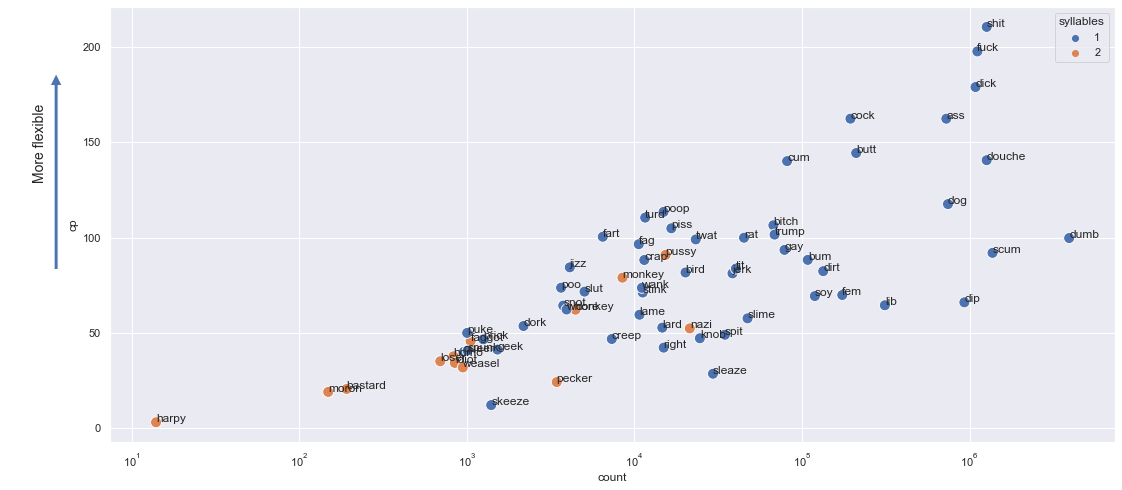

In [7]:
from adjustText import adjust_text
FIG_GEN = 0

FS = (18, 8)
if FIG_GEN:
    FS = (9, 6)

def scatter(af, xcol='count', ycol='cp',
            labels=True, arrow=True, adjust=True,
            **sns_kwargs,
           ):
    
    fig, ax = plt.subplots(figsize=FS)

    sns.scatterplot(
        data=af,
        x=xcol,
        y=ycol,
        ax=ax,
        **sns_kwargs
    )
    ax.set_xscale('log')
    if ycol == 'cp' and False:
        ax.invert_yaxis()
    if labels:
        texts = []
        for aff, row in af.iterrows():
            x = row[xcol]
            y = row[ycol]
            texts.append( ax.text(x, y, aff) )
        if adjust:
            iters = adjust_text(
                texts,
                x=af[xcol].values,
                y=af[ycol].values,
                expand_text=(1.05, 1.2),
                expand_points=(1.2, 1.2),
                arrowprops=dict(arrowstyle='->', color='black'),
                lim=100, # slooooow
            )
            print(f"adjust_text took {iters} iterations.")
    #ax.set_title(f"Prefixes: count vs. collision prob")
    #ax.set_ylabel('')
    if arrow:
        xarrow = .05
        # arrow up
        ax.annotate(
            '',
            xytext=(xarrow, .45),
            xy=(xarrow, .85),
            xycoords='figure fraction',
            textcoords='figure fraction',
            arrowprops=dict(),
        )
        ax.text(
            .065,
            .58,
            'More flexible',
            transform=fig.transFigure,
            rotation=90,
            fontsize=14,
        )
    return fig, ax

scatter(pf, 
        labels=1,
        hue='syllables', palette='deep', s=120,
        adjust=False,
       );

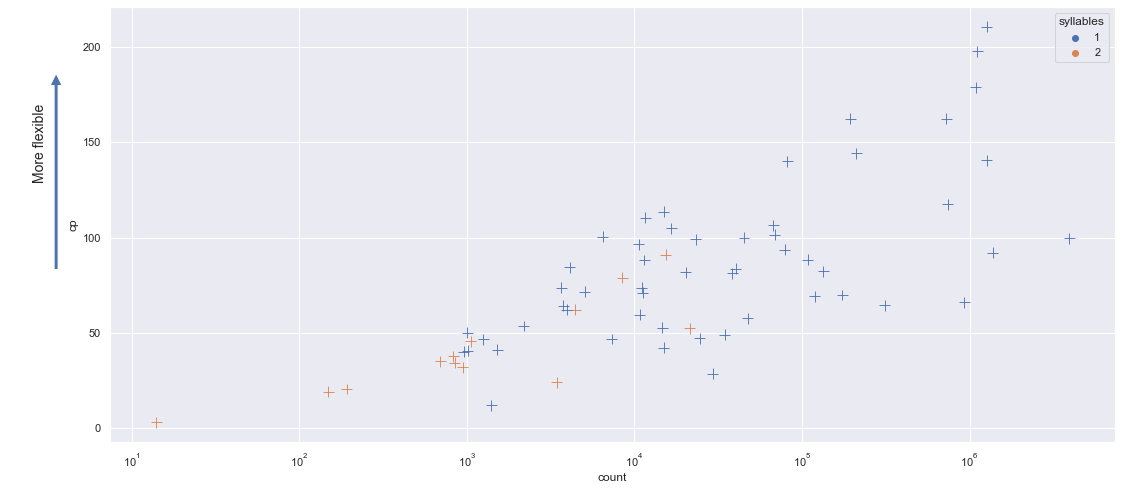

In [8]:
scatter(pf, 
        labels=0,
        hue='syllables', palette='deep', s=120, marker='+',
        adjust=False,
       );

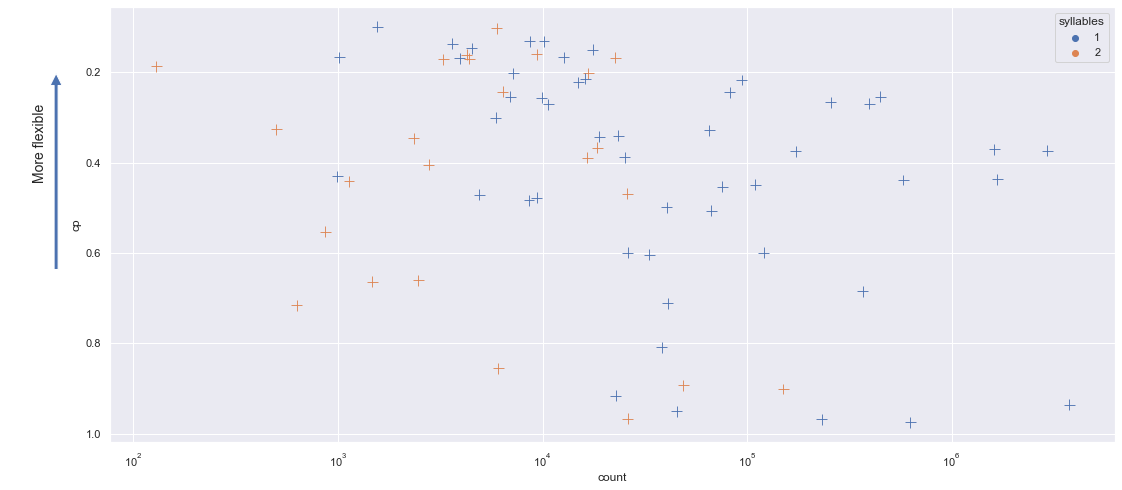

In [92]:
scatter(sf, 
        labels=False,
        hue='syllables', palette='deep', s=120, marker='+',
       );

adjust_text took 6 iterations.


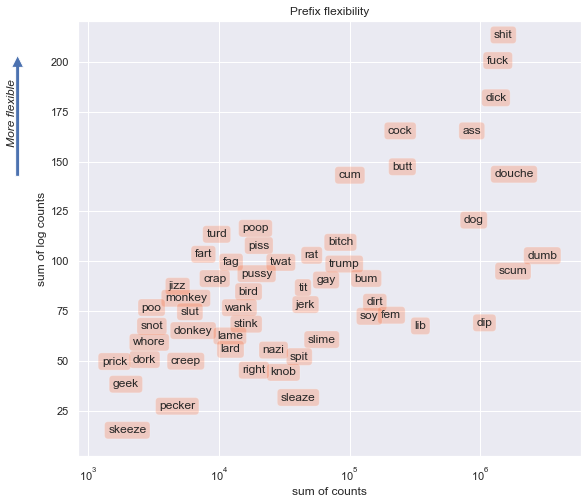

In [22]:
FIG_GEN = 1

# Set to 1 if we're doing the "collision_probability = logsum" hack. Bleh.
LOGSUM = 1

FS = (18, 8)
if FIG_GEN:
    FS = (9, 8)

def scatter_text(af, xcol='count', ycol='cp',
            adjust=True, arrow=True,
                 min=500,
                 textbg='orangered',
            **sns_kwargs,
           ):
    
    fig, ax = plt.subplots(figsize=FS)
    if min:
        af = af[af['count'] >= min]

    sns.scatterplot(
        data=af,
        x=xcol,
        y=ycol,
        ax=ax,
        alpha=0,
        **sns_kwargs
    )
    ax.set_xscale('log')
    if ycol == 'cp' and not LOGSUM:
        ax.invert_yaxis()
    
    texts = []
    for aff, row in af.iterrows():
        x = row[xcol]
        y = row[ycol]
        texts.append( ax.annotate(aff, (x, y), 
                                  bbox=dict(boxstyle='round', alpha=0.2, facecolor=textbg),
                                 ) )
    if adjust:
        iters = adjust_text(
            texts,
            expand_text=(1.05, 1.2),
            lim=100, # slooooow
        )
        print(f"adjust_text took {iters} iterations.")
    if arrow:
        xarrow = .03
        # arrow up
        ax.annotate(
            '',
            xytext=(xarrow, .65),
            xy=(xarrow, .89),
            xycoords='figure fraction',
            textcoords='figure fraction',
            arrowprops=dict(),
        )
        ax.text(
            xarrow - .015,
            .665,
            'More flexible',
            transform=fig.transFigure,
            rotation=90,
            fontsize=12,
            fontstyle='italic',
        )
    return fig, ax

fig, ax = scatter_text(pf, 
        adjust=1,
        min=1055,
       );
ax.set_ylabel("sum of log counts")
ax.set_xlabel("sum of counts")
ax.set_title("Prefix flexibility")
if FIG_GEN:
    viz_helpers.savefig(fig, 'prefix_collisions', bbox_inches='tight');

adjust_text took 100 iterations.


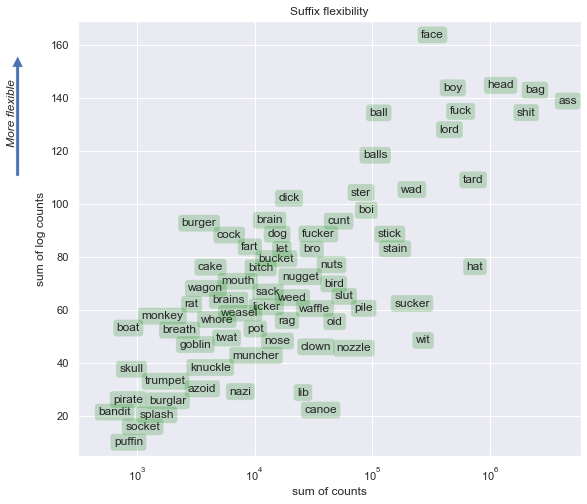

In [26]:
fig, ax = scatter_text(sf, 
                       adjust=1, 
                       min=500,
                       textbg='green',
                       
       );
ax.set_ylabel("sum of log counts")
ax.set_xlabel("sum of counts")
ax.set_title("Suffix flexibility")
if FIG_GEN:
    viz_helpers.savefig(fig, 'suffix_collisions', bbox_inches='tight', dpi=fig.dpi*2);

In [5]:
pf.head(4)

,count,cp,entropy,count_rank,cp_rank,entropy_rank,topmatch,topcount,topcountpct,nzeros,syllables
ass,726783,0.728,-1.117,9,52,52,hat,618186,85.058,2,1
bastard,192,0.087,-4.230,64,4,6,face,39,20.312,41,2
bird,20197,0.169,-3.141,30,21,30,shit,6010,29.757,13,1
bitch,67527,0.345,-2.169,20,37,40,ass,35551,52.647,6,1


In [131]:
ppf = pf.copy()
atcol = 'atype'
ppf[atcol] = 'pre'
ssf = sf.copy()
ssf[atcol] = 'suff'
mega = pd.concat([ppf, ssf])

# Bleh, hack
mega['logcount'] = np.log10(mega['count'])

mega.head()

,count,cp,entropy,count_rank,cp_rank,entropy_rank,topmatch,topcount,topcountpct,nzeros,syllables,atype,logcount
ass,726783,0.728,-1.117,9.0,53.0,53.0,hat,618186,85.058,2,1,pre,5.861
bastard,192,0.087,-4.230,65.0,4.0,6.0,face,39,20.312,41,2,pre,2.283
bird,20197,0.169,-3.141,30.0,22.0,31.0,shit,6010,29.757,13,1,pre,4.305
bitch,67527,0.345,-2.169,20.0,38.0,41.0,ass,35551,52.647,6,1,pre,4.829
bum,108346,0.828,-0.728,16.0,56.0,56.0,fuck,98471,90.886,11,1,pre,5.035


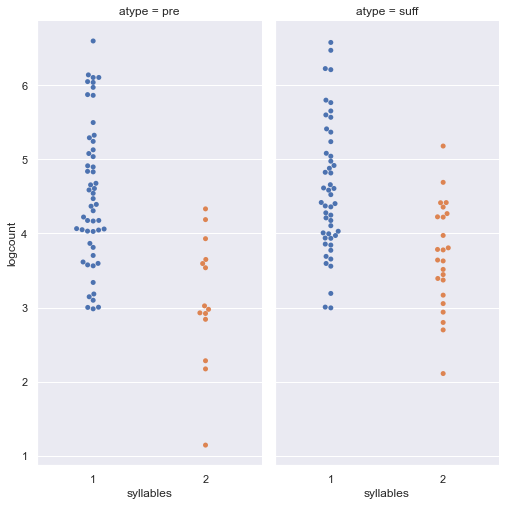

In [146]:
g = sns.catplot(
    data=mega,
    x='syllables',
    y='logcount',
    col=atcol,
    kind='swarm',
    aspect=.5,
    height=7,
    sharey=True,
);
#g.set(yscale='log');
#for ax in g.axes.flatten():
#    ax.set_yscale('log')

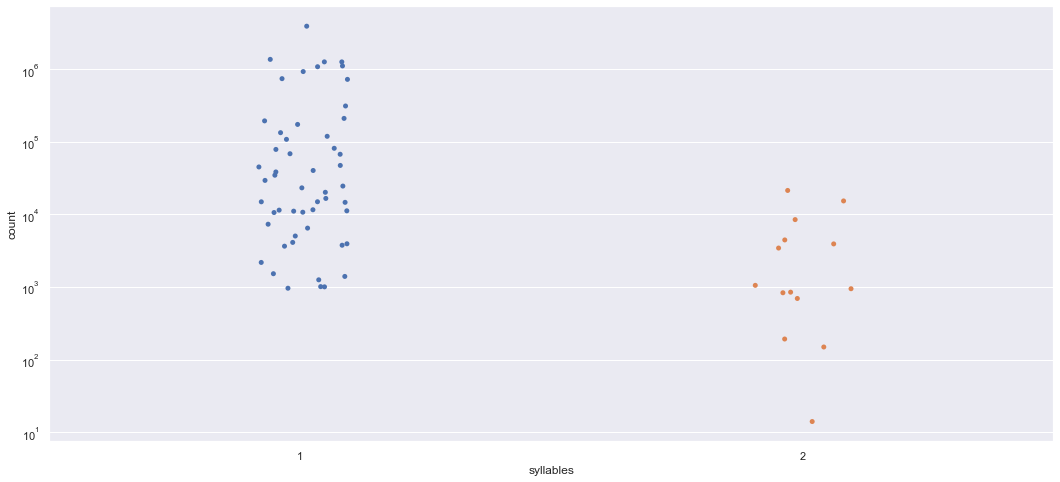

In [111]:
fig, ax = plt.subplots(figsize=FS)
af = pf
sns.stripplot(
    data=af,
    x="syllables",
    y="count",
    ax=ax,
);
ax.set_yscale('log');

In [112]:
ax.get_ylim()

(7.476902410809349, 7356323.645535747)

In [110]:
pf['count'].describe()

count    6.700e+01
mean     2.167e+05
std      5.777e+05
min      1.400e+01
25%      3.710e+03
50%      1.493e+04
75%      8.013e+04
max      3.929e+06
Name: count, dtype: float64

In [6]:
pf.sort_values(by='count_rank').head()

,count,cp,entropy,count_rank,cp_rank,entropy_rank,topmatch,topcount,topcountpct,nzeros,syllables
dumb,3928751,0.857,-0.494,1,61,62,ass,3631048,92.422,13,1
scum,1370798,0.966,-0.169,2,66,66,bag,1347188,98.278,14,1
shit,1266231,0.211,-2.996,3,31,33,head,450560,35.583,0,1
douche,1265155,0.853,-0.597,4,60,59,bag,1167302,92.266,2,1
fuck,1113336,0.131,-3.393,5,19,27,tard,234588,21.071,0,1


In [7]:
sf.sort_values(by='count_rank')

,count,cp,entropy,count_rank,cp_rank,entropy_rank,topmatch,topcount,topcountpct,nzeros,syllables
ass,3754308,0.936,-0.322,1,69,69,dumb,3631048,96.717,4,1
bag,2939955,0.374,-1.796,2,38,50,scum,1347188,45.823,4,1
shit,1667150,0.437,-1.445,3,44,54,dip,863707,51.807,1,1
head,1611393,0.371,-1.875,4,37,48,dick,855756,53.107,3,1
hat,626150,0.975,-0.139,5,73,73,ass,618186,98.728,13,1
tard,579832,0.439,-1.441,6,45,55,lib,302488,52.168,7,1
fuck,447426,0.255,-2.585,7,25,29,dumb,191951,42.901,2,1
boy,395352,0.270,-2.318,8,28,34,fem,133608,33.795,2,1
lord,367655,0.685,-1.091,9,61,62,shit,300942,81.854,1,1
face,256361,0.267,-3.007,10,27,22,fuck,125768,49.059,1,1


In [154]:
poli_pres = ['lib', 'right', 'soy', 'trump']
pf.loc[poli_pres]

,count,cp,entropy,count_rank,cp_rank,entropy_rank,topmatch,topcount,topcountpct,nzeros,syllables
lib,312305,0.939,-0.258,10,66,66,tard,302488,96.857,21,1
right,14959,0.846,-0.687,33,59,58,oid,13748,91.905,31,1
soy,119354,0.850,-0.591,15,60,61,boy,109940,92.113,18,1
trump,68645,0.410,-1.782,19,43,45,tard,31073,45.266,9,1


In [156]:
len(sf)

73

In [155]:
df[df.pre == 'trump'].sort_values(by='count').head(20)

,pre,suff,count,wikt
4270,trump,nozzle,0.0,False
4280,trump,mitten,0.0,False
4305,trump,lib,0.0,False
4263,trump,bandit,0.0,False
4256,trump,pirate,0.0,False
4248,trump,puffin,0.0,False
4247,trump,goblin,0.0,False
4306,trump,breath,0.0,False
4239,trump,splash,0.0,False
4294,trump,nose,1.0,False


In [8]:
pf.sort_values(by='cp_rank')

,count,cp,entropy,count_rank,cp_rank,entropy_rank,topmatch,topcount,topcountpct,nzeros,syllables
turd,11603,0.065,-4.555,36,1,1,burger,1666,14.358,6,1
moron,149,0.070,-4.434,65,2,4,face,25,16.779,43,2
puke,1005,0.074,-4.475,58,3,3,face,183,18.209,20,1
bastard,192,0.087,-4.230,64,4,6,face,39,20.312,41,2
monkey,8489,0.089,-4.009,42,5,11,ball,1323,15.585,17,2
snot,3765,0.100,-3.876,49,6,17,rag,600,15.936,16,1
homo,833,0.100,-3.962,62,7,12,goblin,165,19.808,29,2
jizz,4118,0.100,-4.220,47,8,7,rag,993,24.114,3,1
prick,1256,0.102,-4.036,55,9,10,face,247,19.666,24,1
pussy,15350,0.102,-3.859,32,10,18,hat,2875,18.730,11,2


In [9]:
sf.sort_values(by='cp_rank')

,count,cp,entropy,count_rank,cp_rank,entropy_rank,topmatch,topcount,topcountpct,nzeros,syllables
boat,1548,0.101,-4.080,65,1,1,shit,345,22.287,16,1
wagon,5985,0.103,-3.760,53,2,3,shit,1083,18.095,11,2
brains,8653,0.132,-3.343,47,3,11,cum,1594,18.421,10,1
fart,10161,0.132,-3.599,43,4,4,dog,2639,25.972,14,1
rat,3614,0.138,-3.838,60,5,2,shit,1134,31.378,8,1
whore,4486,0.149,-3.347,56,6,10,cum,1240,27.642,17,1
brain,17616,0.151,-3.437,36,7,8,bird,4353,24.710,6,1
burger,9375,0.161,-3.501,45,8,5,ass,2588,27.605,6,2
monkey,4232,0.163,-3.461,58,9,7,butt,1403,33.152,12,2
dog,12666,0.168,-3.324,41,10,13,rat,3548,28.012,5,1


In [8]:
fcol = mat.loc[:, 'fuck']
100 * fcol / (fcol.sum())

pre
ass        3.111e+00
bastard    4.023e-03
bird       9.164e-03
bitch      8.739e-02
bum        2.201e+01
butt       1.136e+01
cock       1.149e-01
crap       2.414e-02
creep      1.095e-02
cum        3.867e-02
dick       5.366e-01
dip        4.023e-01
dirt       7.376e-03
dog        1.140e-01
donkey     2.190e-02
dork       2.682e-03
douche     3.858e-01
dumb       4.290e+01
fag        2.995e-02
faggot     1.296e-02
fart       1.386e-02
fem        3.129e-03
fuck       8.752e-01
gay        2.883e-02
geek       6.705e-04
harpy      0.000e+00
homo       8.940e-03
idiot      9.164e-03
jerk       8.940e-03
jizz       2.906e-03
knob       2.459e-03
lame       1.296e-02
lard       8.493e-03
lib        4.269e-02
loser      7.599e-03
monkey     5.610e-02
moron      8.940e-04
nazi       6.258e-03
pecker     2.235e-04
piss       4.984e-02
poo        5.364e-03
poop       1.565e-02
prick      8.046e-03
puke       8.940e-03
pussy      1.207e-01
queer      2.906e-03
rat        3.905e+00
right    

In [10]:
pset = set(pf.index.to_list())
sset = set(sf.index.to_list())
inter = set.intersection(pset, sset)

print(
    len(pset),
    len(sset),
    len(inter),
)

66 73 17


In [11]:
inter

{'ass',
 'bird',
 'bitch',
 'cock',
 'dick',
 'dog',
 'fart',
 'fuck',
 'lib',
 'monkey',
 'nazi',
 'rat',
 'shit',
 'slut',
 'twat',
 'weasel',
 'whore'}

In [14]:
df.sort_values(by='count', ascending=False)

,pre,suff,count
1948,dumb,ass,3.631e+06
3140,scum,bag,1.347e+06
2337,douche,bag,1.167e+06
2696,dip,shit,8.637e+05
1222,dick,head,8.558e+05
...,...,...,...
3090,lard,nazi,0.000e+00
3088,lard,pirate,0.000e+00
3087,lard,slut,0.000e+00
3080,lard,puffin,0.000e+00


In [18]:
df[df['count'] == 1].sample(10, random_state=1)

,pre,suff,count
2936,whore,muncher,1.0
2401,douche,azoid,1.0
2491,dork,monkey,1.0
377,puke,bird,1.0
2746,nazi,trumpet,1.0
2779,geek,splash,1.0
4745,faggot,wad,1.0
4620,loser,slut,1.0
2843,geek,fart,1.0
84,snot,rat,1.0


In [13]:
.987**2

0.974169

In [16]:
denom = df[df.suff=='fuck']['count'].sum()

pred = dict(
dumb = 191951,
bum = 98471,
    butt=50818,
    tit=30802,
    rat=17471,
)

for pref, count in pred.items():
    proportion = count / denom
    print(f"{pref}fuck: {proportion*100:.1f}%, cp = {100 * proportion**2:.1f}%")
    

dumbfuck: 42.9%, cp = 18.4%
bumfuck: 22.0%, cp = 4.8%
buttfuck: 11.4%, cp = 1.3%
titfuck: 6.9%, cp = 0.5%
ratfuck: 3.9%, cp = 0.2%


In [15]:
df[df.suff=='fuck']['count'].sum()

447425.77499999997

In [17]:
df[df.suff=='fuck'].sort_values(by='count', ascending=False).head(10)

,pre,suff,count
1965,dumb,fuck,191951.050
1162,bum,fuck,98471.400
1016,butt,fuck,50818.450
1746,tit,fuck,30802.750
3717,rat,fuck,17471.125
651,shit,fuck,15540.000
1089,ass,fuck,13918.000
3206,scum,fuck,12741.000
1819,fuck,fuck,3916.000
1235,dick,fuck,2401.000


In [20]:
mat.loc['poop', 'face']

2398.0

In [18]:
pf.loc['faggot']

count           1054
cp              45.7
entropy        -4.05
count_rank        56
cp_rank           15
entropy_rank       9
topmatch         ass
topcount         319
topcountpct     30.3
nzeros            22
syllables          2
Name: faggot, dtype: object

In [20]:
#mat.loc[:, 'puffin']